# Segmentation Network Unet

In [12]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
from glob import glob
from random import choice, sample
from scipy import ndimage
from scipy.ndimage import morphology as mp
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Concatenate, Conv2DTranspose,
                                     BatchNormalization, Activation, Dropout, UpSampling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.callbacks import (TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16, VGG19

ModuleNotFoundError: No module named 'cv2'

# Listing image and their respective labels 
also here we are asserting the presence of label file w.r.t each image.

In [3]:
train_img_dir = '../input/concatenation-endo/cropped_train/instrument_dataset_1/images/' 
train_mask_dir = '../input/concatenation-endo/cropped_train/instrument_dataset_1/binary_masks/'
train_imgs = os.listdir(train_img_dir)# if you have an error take a look here ...
train_masks = os.listdir(train_mask_dir)
train_imgs= sorted([ i for i in train_imgs ])
train_masks= sorted([ i for i in train_masks ])
print(len(train_imgs))
print(len(train_masks))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input/concatenation-endo/cropped_train/instrument_dataset_1/images/'

In [6]:
print(train_imgs[:3])
print(train_masks[:3])

['frame000.jpg', 'frame000_h.jpg', 'frame000_v.jpg']
['frame000.png', 'frame000_h.png', 'frame000_v.png']


**Repeat same steps for validation dataset**

In [ ]:
val_img_dir =  train_img_dir
val_mask_dir = train_mask_dir
val_imgs = train_imgs[-25:]#os.listdir(val_mask_dir)
val_masks = train_masks[-25:]#os.listdir(val_mask_dir)
train_imgs = train_imgs[:-25]
train_masks = train_masks[:-25]

In [8]:
print(len(val_imgs))
print(len(val_masks))

25
25


# Here we impliment keras custom data generator to get batch images and labels without loading whole dataset in the active memory

In [6]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, images,image_dir,labels,label_dir ,batch_size=16, dim=(224,224,3) ,shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.image_dir = image_dir
        self.labels = labels
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            img = load_img(self.image_dir + self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.

            batch_imgs.append(img)
           # Store class
            label = load_img(self.label_dir + self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)
            
        return np.array(batch_imgs,dtype = np.float32 ) ,np.array(batch_labels , dtype = np.float32 )

 **Now we need to define our training and validation generator using above implimented class.**

In [10]:
# Instantiate training data generator
train_generator = DataGenerator(
    train_imgs, train_img_dir, train_masks, train_mask_dir,
    batch_size=36, dim=(224, 224, 3), shuffle=True
)
train_steps = train_generator.__len__()
print(f"Training steps per epoch: {train_steps}")

Training steps per epoch: 18


In [11]:
# Instantiate validation data generator
val_generator = DataGenerator(
    val_imgs, val_img_dir, val_masks, val_mask_dir,
    batch_size=36, dim=(224, 224, 3), shuffle=True
)
val_steps = val_generator.__len__()
print(f"Validation steps per epoch: {val_steps}")

Validation steps per epoch: 0


# Data Visualisaton

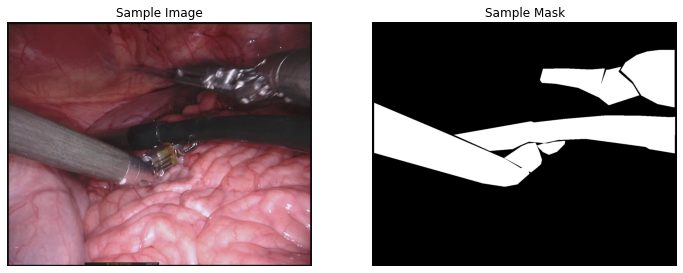

In [12]:
# Visualizing a sample image and its corresponding mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sample_image = load_img(os.path.join(train_img_dir, train_imgs[0]))
plt.imshow(sample_image)
plt.title("Sample Image")
plt.axis('off')

plt.subplot(1, 2, 2)
sample_mask = load_img(os.path.join(train_mask_dir, train_masks[0]))
plt.imshow(sample_mask)
plt.title("Sample Mask")
plt.axis('off')

plt.show()

In [13]:
X,y = train_generator.__getitem__(1)
t = 12

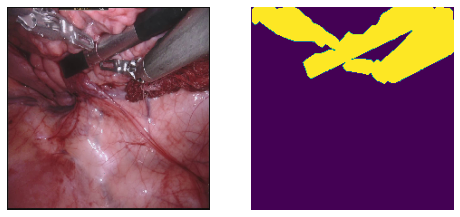

In [14]:
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(X[t])

plt.subplot(122)
plt.axis('off')
plt.imshow(np.reshape(y[t],(224,224)))

# Model Definitions

### U-Net with VGG16 Backbone

In [15]:
def conv_block(inputs,filterCount):
    x = Conv2D(filterCount,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filterCount,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [16]:
def decoder_block(inputs,skip_features,filter_count):
    
    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filter_count)
    return x

In [17]:
def unet_vgg16(input_shape):
    inputs = Input(input_shape)
    print(inputs.shape)
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor = inputs)
    #vgg16.summary()
    # the encoder 
    skip1 = vgg16.get_layer("block1_conv2").output
    print(skip1.shape)
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output
    # the center
    center = vgg16.get_layer("block5_conv3").output
    
    # the decoder 
    
    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)
    #output
    #conv1 = Conv2D(32,3,padding="same")(d4)
    #conv2 = Conv2D(16,3,padding="same")(conv1)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [18]:
input_shape = (224,224,3)
model_vgg16 = unet_vgg16(input_shape)
model_vgg16.summary()

(None, 224, 224, 3)
58892288/58889256 [==============================] - 0s 0us/step
(None, 224, 224, 64)
Model: "VGG16_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][

### U-Net with VGG19 Backbone

In [10]:
def unet_vgg19(input_shape):
    inputs = Input(input_shape)
    vgg19 = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)

    # Encoder: Extract the skip connections
    skip1 = vgg19.get_layer("block1_conv2").output
    skip2 = vgg19.get_layer("block2_conv2").output
    skip3 = vgg19.get_layer("block3_conv4").output
    skip4 = vgg19.get_layer("block4_conv4").output

    # Center block
    center = vgg19.get_layer("block5_conv4").output

    # Decoder blocks
    d1 = decoder_block(center, skip4, 512)
    d2 = decoder_block(d1, skip3, 256)
    d3 = decoder_block(d2, skip2, 128)
    d4 = decoder_block(d3, skip1, 64)

    # Output layer
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

In [20]:
input_shape = (224, 224, 3)
model_vgg19 = unet_vgg19(input_shape)
model_vgg19.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "VGG19_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________

### Custom U-Net Model

In [21]:
def custom_encoder(input_layer):
    # Custom convolutional blocks
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    center = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    center = Conv2D(1024, (3, 3), activation='relu', padding='same')(center)

    return conv1, conv2, conv3, conv4, center

def decoder_block(input_tensor, skip_tensor, num_filters):
    up = UpSampling2D((2, 2))(input_tensor)
    concat = Concatenate()([up, skip_tensor])
    conv = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(concat)
    conv = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(conv)
    return conv

def unet_custom(input_shape):
    inputs = Input(input_shape)
    
    # Encoder part
    skip1, skip2, skip3, skip4, center = custom_encoder(inputs)
    
    # Decoder part
    d1 = decoder_block(center, skip4, 512)
    d2 = decoder_block(d1, skip3, 256)
    d3 = decoder_block(d2, skip2, 128)
    d4 = decoder_block(d3, skip1, 64)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(d4)
    model = Model(inputs, outputs, name="Custom_U-Net")
    return model

In [22]:
# Instantiate and compile the custom U-Net
input_shape = (224, 224, 3)
model_custom = unet_custom(input_shape)
model_custom.summary()

Model: "Custom_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_19[0][0]                  
_______________________________________________________________________________________

# Loss Functions and Metrics

Jaccard distance loss - this loss help to get rid of the side effects of unbalanced class label in a image (like - 80% background , 20 % human ) [ https://en.wikipedia.org/wiki/Jaccard_index](http://)

dice_coef - To evaluate accuracy of the segmentation.  [ https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient](http://)

In [23]:
def jaccard_distance_loss(y_true, y_pred,smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Model Compilation and Callbacks

## Compile VGG16 U-Net Model

In [24]:
# Compile VGG16 U-Net model
model_vgg16 = unet_vgg16(input_shape=(224, 224, 3))
model_vgg16.compile(optimizer='adam', loss=jaccard_distance_loss, metrics=[dice_coef, 'accuracy'])

# Define callbacks for VGG16 U-Net
mc_vgg16 = ModelCheckpoint(
    filepath='top-weights-vgg16.h5',
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
es_vgg16 = EarlyStopping(
    monitor='val_dice_coef',
    mode='max',
    patience=3,
    verbose=1
)
callbacks_vgg16 = [mc_vgg16, es_vgg16]

# Display model metrics names
print("VGG16 U-Net Model Metrics Names:", model_vgg16.metrics_names)


(None, 224, 224, 3)
(None, 224, 224, 64)
VGG16 U-Net Model Metrics Names: []


## Compile VGG19 U-Net Model

In [25]:
# Compile VGG19 U-Net model
model_vgg19 = unet_vgg19(input_shape=(224, 224, 3))
model_vgg19.compile(optimizer='adam', loss=jaccard_distance_loss, metrics=[dice_coef, 'accuracy'])

# Define callbacks for VGG19 U-Net
mc_vgg19 = ModelCheckpoint(
    filepath='top-weights-vgg19.h5',
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
es_vgg19 = EarlyStopping(
    monitor='val_dice_coef',
    mode='max',
    patience=3,
    verbose=1
)
callbacks_vgg19 = [mc_vgg19, es_vgg19]

# Display model metrics names
print("VGG19 U-Net Model Metrics Names:", model_vgg19.metrics_names)


VGG19 U-Net Model Metrics Names: []


## Compile Custom U-Net Model

In [26]:
# Compile Custom U-Net model
model_custom = unet_custom(input_shape=(224, 224, 3))
model_custom.compile(optimizer='adam', loss=jaccard_distance_loss, metrics=[dice_coef, 'accuracy'])

# Define callbacks for Custom U-Net
mc_custom = ModelCheckpoint(
    filepath='top-weights-custom.h5',
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
es_custom = EarlyStopping(
    monitor='val_dice_coef',
    mode='max',
    patience=3,
    verbose=1
)
callbacks_custom = [mc_custom, es_custom]

# Display model metrics names
print("Custom U-Net Model Metrics Names:", model_custom.metrics_names)


Custom U-Net Model Metrics Names: []


# Train our models with above configurations and train data generator.

## U-net VGG16

In [28]:
if not (os.path.isfile('../input/linknet/top-weights-vgg16.h5')):
    # Train VGG16 U-Net model
    results_vgg16 = model_vgg16.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=40,
        callbacks=callbacks_vgg16,
        validation_data=val_generator,
        validation_steps=val_steps
    )
else:
    model_vgg16.load_weights('../input/linknet/top-weights-vgg16.h5')

Epoch 1/40
18/18 [==============================] - 200s 11s/step - loss: 0.1969 - dice_coef: 1.3433e-10 - accuracy: 0.8011
Epoch 2/40
18/18 [==============================] - 199s 11s/step - loss: 0.1971 - dice_coef: 2.7880e-13 - accuracy: 0.8009
Epoch 3/40
18/18 [==============================] - 199s 11s/step - loss: 0.1970 - dice_coef: 2.7923e-13 - accuracy: 0.8010
Epoch 4/40
18/18 [==============================] - 199s 11s/step - loss: 0.1970 - dice_coef: 2.7865e-13 - accuracy: 0.8010
Epoch 5/40
18/18 [==============================] - 199s 11s/step - loss: 0.1972 - dice_coef: 2.7869e-13 - accuracy: 0.8009
Epoch 6/40
18/18 [==============================] - 199s 11s/step - loss: 0.1971 - dice_coef: 2.7914e-13 - accuracy: 0.8010
Epoch 7/40
18/18 [==============================] - 199s 11s/step - loss: 0.1970 - dice_coef: 2.7899e-13 - accuracy: 0.8011
Epoch 8/40
18/18 [==============================] - 199s 11s/step - loss: 0.1972 - dice_coef: 2.7896e-13 - accuracy: 0.8008
Epoch 9/

In [36]:
model_vgg16.save_weights('top-weights-vgg16.h5')

In [37]:
results_vgg16.history.keys()

dict_keys(['loss', 'dice_coef', 'accuracy'])

In [38]:
loss = results_vgg16.history["loss"]
# val_loss = results.history["val_loss"]

dice_coef = results_vgg16.history["dice_coef"]
# val_dice_coef = results.history["val_dice_coef"]

acc = results_vgg16.history["accuracy"]
# val_acc = results.history["val_accuracy"]

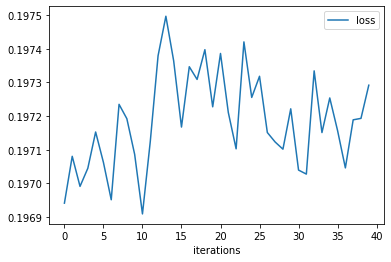

In [39]:
plt.plot(loss,label = "loss")
# plt.plot(val_loss,label  = "val loss")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

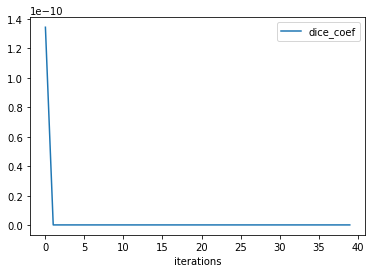

In [40]:
plt.plot(dice_coef,label = "dice_coef")
# plt.plot(val_dice_coef,label  = "val dice_coef")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

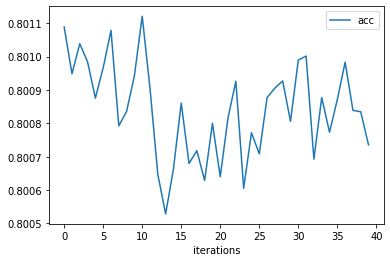

In [41]:
plt.plot(acc,label = "acc")
# plt.plot(val_acc,label  = "val acc")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

## U-net VGG19

In [29]:
if not (os.path.isfile('../input/linknet/top-weights-vgg19.h5')):
    # Train VGG16 U-Net model
    results_vgg19 = model_vgg19.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=40,
        callbacks=callbacks_vgg16,
        validation_data=val_generator,
        validation_steps=val_steps
    )
else:
    model_vgg16.load_weights('../input/linknet/top-weights-vgg19.h5')

Epoch 1/40
18/18 [==============================] - 215s 12s/step - loss: 0.2192 - dice_coef: 0.0419 - accuracy: 0.8006
Epoch 2/40
18/18 [==============================] - 215s 12s/step - loss: 0.1945 - dice_coef: 2.8220e-13 - accuracy: 0.8036
Epoch 3/40
18/18 [==============================] - 215s 12s/step - loss: 0.1987 - dice_coef: 2.7693e-13 - accuracy: 0.7993
Epoch 4/40
18/18 [==============================] - 215s 12s/step - loss: 0.1947 - dice_coef: 2.8246e-13 - accuracy: 0.8034
Epoch 5/40
18/18 [==============================] - 216s 12s/step - loss: 0.1963 - dice_coef: 2.7995e-13 - accuracy: 0.8018
Epoch 6/40
18/18 [==============================] - 215s 12s/step - loss: 0.1983 - dice_coef: 2.7739e-13 - accuracy: 0.7997
Epoch 7/40
18/18 [==============================] - 215s 12s/step - loss: 0.1922 - dice_coef: 2.8689e-13 - accuracy: 0.8059
Epoch 8/40
18/18 [==============================] - 215s 12s/step - loss: 0.1993 - dice_coef: 2.7602e-13 - accuracy: 0.7987
Epoch 9/40
1

In [30]:
model_vgg19.save_weights('top-weights-vgg19.h5')

In [31]:
results_vgg19.history.keys()

dict_keys(['loss', 'dice_coef', 'accuracy'])

In [32]:
loss = results_vgg19.history["loss"]
# val_loss = results.history["val_loss"]

dice_coef = results_vgg19.history["dice_coef"]
# val_dice_coef = results.history["val_dice_coef"]

acc = results_vgg19.history["accuracy"]
# val_acc = results.history["val_accuracy"]

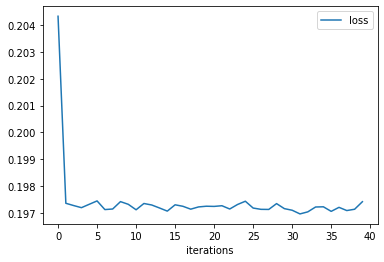

In [33]:
plt.plot(loss,label = "loss")
# plt.plot(val_loss,label  = "val loss")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

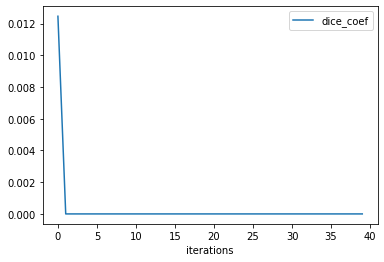

In [34]:
plt.plot(dice_coef,label = "dice_coef")
# plt.plot(val_dice_coef,label  = "val dice_coef")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

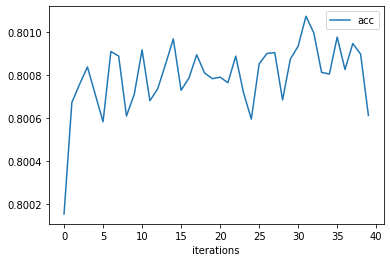

In [35]:
plt.plot(acc,label = "acc")
# plt.plot(val_acc,label  = "val acc")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

## U-net Custom Model

In [42]:
if not (os.path.isfile('../input/linknet/top-weights-custom-m.h5')):
    results_custom = model_custom.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=40,
        callbacks=callbacks_vgg16,
        validation_data=val_generator,
        validation_steps=val_steps
    )
else:
    model_custom.load_weights('../input/linknet/top-weights-custom-m.h5')

Epoch 1/40
18/18 [==============================] - 223s 11s/step - loss: 0.2813 - dice_coef: 0.0856 - accuracy: 0.6890
Epoch 2/40
18/18 [==============================] - 197s 11s/step - loss: 0.1993 - dice_coef: 2.7597e-13 - accuracy: 0.7987
Epoch 3/40
18/18 [==============================] - 197s 11s/step - loss: 0.1976 - dice_coef: 2.7858e-13 - accuracy: 0.8004
Epoch 4/40
18/18 [==============================] - 197s 11s/step - loss: 0.1973 - dice_coef: 2.7815e-13 - accuracy: 0.8007
Epoch 5/40
18/18 [==============================] - 197s 11s/step - loss: 0.1992 - dice_coef: 2.7557e-13 - accuracy: 0.7988
Epoch 6/40
18/18 [==============================] - 197s 11s/step - loss: 0.1974 - dice_coef: 2.7815e-13 - accuracy: 0.8006
Epoch 7/40
18/18 [==============================] - 197s 11s/step - loss: 0.1934 - dice_coef: 2.8505e-13 - accuracy: 0.8046
Epoch 8/40
18/18 [==============================] - 197s 11s/step - loss: 0.2017 - dice_coef: 2.7254e-13 - accuracy: 0.7963
Epoch 9/40
1

In [43]:
model_custom.save_weights('top-weights-custom-m.h5')

In [44]:
results_custom.history.keys()

dict_keys(['loss', 'dice_coef', 'accuracy'])

In [45]:
loss = results_custom.history["loss"]
# val_loss = results.history["val_loss"]

dice_coef = results_custom.history["dice_coef"]
# val_dice_coef = results.history["val_dice_coef"]

acc = results_custom.history["accuracy"]
# val_acc = results.history["val_accuracy"]

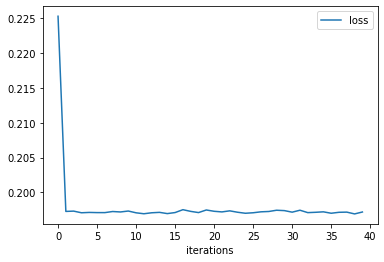

In [46]:
plt.plot(loss,label = "loss")
# plt.plot(val_loss,label  = "val loss")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

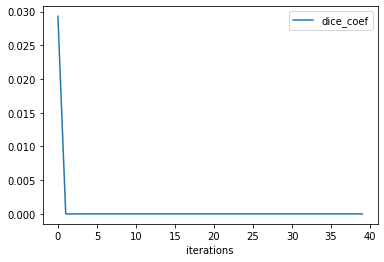

In [47]:
plt.plot(dice_coef,label = "dice_coef")
# plt.plot(val_dice_coef,label  = "val dice_coef")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

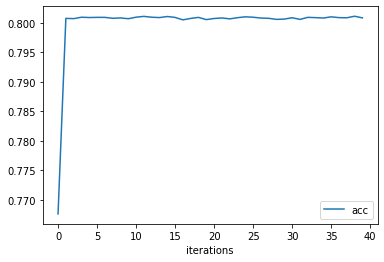

In [48]:
plt.plot(acc,label = "acc")
# plt.plot(val_acc,label  = "val acc")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

# Predictions

**Function to make prediction 
Note:-  Dont forget to Normalise image dataset (here i divided every pixel by 255. )**

In [8]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)
    mask = (mask[0] > 0.5)*1
#   print(np.unique(mask,return_counts=True))
    mask = np.reshape(mask,(224,224))
    return mask

In [10]:
image = "/kaggle/input/concatenation-endo/cropped_train/instrument_dataset_1/images/frame000.jpg"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/concatenation-endo/cropped_train/instrument_dataset_1/images/frame000.jpg'

(1024, 1280, 3) (224, 224, 3)


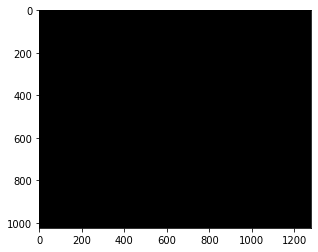

In [92]:
mask = make_prediction(model_vgg16,image,(224,224,3))
mask2 = cv2.merge([mask,mask,mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
# print(mask.shape)
plt.imshow(mask2)

**Now use the mask to get the segmented image**

In [93]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
mask_resized = mask_resized != 0
#print(np.unique(mask_resized,return_counts=True))
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]
#img[np.where((img==[255,255,255]).all(axis=2))] = [0,0,0];

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)

NameError: name 'plt' is not defined

In [95]:
def make_prediction(model, image_path, shape):
    img = img_to_array(load_img(image_path, target_size=shape)) / 255.0
    img_expanded = np.expand_dims(img, axis=0)
    
    # Predict the mask
    mask = model.predict(img_expanded)
    mask = (mask[0] > 0.5).astype(np.float32)
    
    return img, mask

In [4]:
# Set the path to the image you want to test
image_path = "/kaggle/input/concatenation-endo/cropped_train/instrument_dataset_1/images/frame000.jpg"

# Generate predictions for both models
img_original, mask_vgg16 = make_prediction(model_vgg16, image_path, input_shape)
_, mask_vgg19 = make_prediction(model_vgg19, image_path, input_shape)

# Convert masks to 3-channel for visualization
mask_vgg16_rgb = cv2.merge([mask_vgg16]*3)
mask_vgg19_rgb = cv2.merge([mask_vgg19]*3)

# Resize masks to match the original image dimensions
img_original_resized = cv2.resize(img_original, (mask_vgg16_rgb.shape[1], mask_vgg16_rgb.shape[0]))

NameError: name 'make_prediction' is not defined

In [6]:
# Visualize the original image and predictions from both models
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(img_original_resized)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(mask_vgg16_rgb)
plt.title("VGG16 U-Net Prediction")

plt.subplot(1, 3, 3)
plt.imshow(mask_vgg19_rgb)
plt.title("VGG19 U-Net Prediction")

plt.show()

NameError: name 'plt' is not defined